In [ ]:
#data prep.solvents not used yet

from egnn_pytorch import EGNN_Network
import torch.nn as nn
import numpy as np
import random
import torch
from matplotlib import pyplot as plt
import glob
from collections import defaultdict, OrderedDict
import dask.dataframe as dd
import math
anions = {"HIS":("ND1", "ND2"),
        "ASP":("OD1","OD2"),
        "LYS":("NZ"),
        "TYR":("OH"),
        "GLU":("OE1", "OE2"),
        "CYS":("SG")}

from sklearn.neighbors import NearestNeighbors


elements = {
    "H": 1, "He": 2, "Li": 3, "Be": 4, "B": 5, "C": 6, "N": 7, "O": 8, "F": 9, "Ne": 10,
    "Na": 11, "Mg": 12, "Al": 13, "Si": 14, "P": 15, "S": 16, "Cl": 17, "Ar": 18, "K": 19,
    "Ca": 20, "Sc": 21, "Ti": 22, "V": 23, "Cr": 24, "Mn": 25, "Fe": 26, "Co": 27, "Ni": 28,
    "Cu": 29, "Zn": 30, "Ga": 31, "Ge": 32, "As": 33, "Se": 34, "Br": 35, "Kr": 36, "Rb": 37,
    "Sr": 38, "Y": 39, "Zr": 40, "Nb": 41, "Mo": 42, "Tc": 43, "Ru": 44, "Rh": 45, "Pd": 46,
    "Ag": 47, "Cd": 48, "In": 49, "Sn": 50, "Sb": 51, "I": 53, "Xe": 54, "Cs": 55, "Ba": 56,
    "La": 57, "Ce": 58, "Pr": 59, "Nd": 60, "Pm": 61, "Sm": 62, "Eu": 63, "Gd": 64, "Tb": 65,
    "Dy": 66, "Ho": 67, "Er": 68, "Tm": 69, "Yb": 70, "Lu": 71, "Hf": 72, "Ta": 73, "W": 74,
    "Re": 75, "Os": 76, "Ir": 77, "Pt": 78, "Au": 79, "Hg": 80, "Tl": 81, "Pb": 82, "Bi": 83,
    "Po": 84, "At": 85, "Rn": 86, "Fr": 87, "Ra": 88, "Ac": 89, "Th": 90, "Pa": 91, "U": 92,
    "Np": 93, "Pu": 94, "Am": 95, "Cm": 96, "Bk": 97, "Cf": 98, "Es": 99, "Fm": 100, "Md": 101,
    "No": 102, "Lr": 103, "Rf": 104, "Db": 105, "Sg": 106, "Bh": 107, "Hs": 108, "Mt": 109,
    "Ds": 110, "Rg": 111, "Cn": 112, "Nh": 113, "Fl": 114, "Mc": 115, "Lv": 116, "Ts": 117,
    "Og": 118
}

class prepper():
    """This class aims to aggregate all of the information needed to generate an input into my model, 
    as well as a option to gather information needed  to train the model, and any additional components 
    needed for further training, including potential optional information for validating or developing.
    
    Ideally, this will include an option to download on the fly like pypka and other modern technology 
    provides. 
    
    My decisions made here are based off efficiency, bearing in mind flexibility to operating systems 
    ranging from openSUSE to macOS. Thus I aim to minimize bash scripts, at least for this class,
    which shall constitute my data prep (that being, all data used as present and future inputs,
    to train, validate, and analyze the model)
    
    This script shall rely on parsing a pdb, potentially biopython for neighborhood generation, and
    """
    def __init__(self, directory):
        self.directory = directory

    def load_pdb(self, path):
        """loads everything"""
        
        solvents, counter = {}, 0
        with open(path, "r") as f:
            resis, xs, counter = {}, [], 0
            for line in f:
                L = line.split()
                if line.startswith("ATOM"):
                    resname, atomname = L[3], L[2]
                    resname = resname + str(L[5]) + L[4]

                    if resname in resis:
                        resis[resname][f"{atomname} {counter}"] = (float(L[6]), float(L[7]), float(L[8]))
                        counter += 1

                    else:
                        resis[resname] = {f"{atomname} {counter}": (float(L[6]), float(L[7]), float(L[8]))}
                        counter += 1

                elif line.startswith("HETATM"):
                    resname = L[3] + str(L[5])
                    atomname = L[2]
                    if resname in solvents:
                        solvents[resname][f"{atomname} {str(counter)}"] = (float(L[6]), float(L[7]), float(L[8]))
                        counter += 1
                    else:
                        solvents[resname] = {f"{atomname} {str(counter)}": (float(L[6]), float(L[7]), float(L[8]))}
                    counter += 1
                    
        return resis, solvents

    def get_pdbs_list(self):
        """get the list of pdbs from the dictionary keys of "data".
        inputs: path to directory where input structures are saved"""
        directory=self.directory
        pdbids, data =[],{}
        solvents={}
        for file in glob.glob(directory + "/PDB/*red.pdb"):
            pdbid = file[-12:-8]
            data[pdbid], solvents[pdbid] = self.load_pdb(file)
            pdbids.append(pdbid)
        
        self.pdbs = pdbids
        self.residues, self.solvent = data, solvents
        return

    def get_data(self):
        """returns dictionary of data with pdbids as keys and residueid indexed positions, atomic node and species information, input features (hydrogen indices), and the number of atoms in each sample (residue).
        all_species: {199l: {ASP1A : {CA:1} , ..., {TYR100 : {OXT:1032} } """
        
        all_pos, all_species, all_lengths = {},{},{}
        counter=0
        data,sdata = self.residues, self.solvent
        for pdb in self.pdbs:
            resis,solvents = data[pdb],sdata[pdb]
        #####residues##########
            lengths, species, R ={}, {}, OrderedDict()
            for resid, vals in resis.items(): 
                counter, resi_pos, resi_species = 0,{},{}
                for atom, pos in vals.items():
                    node = atom.split() 
                    atomname =node[0] 
                    resi_pos[counter] = pos
                    resi_species[atomname] = counter
                    counter +=1
                species[resid] = resi_species 
                R[resid] = resi_pos
                lengths[resid] = counter
            all_pos[pdb]= R
            all_species[pdb] = species
            all_lengths[pdb] = lengths
        #dicts = (all_ions, all_feats, all_pos, all_lengths, {k: v for k, v in all_targets.items() if not k.startswith('N') or k.startswith("CT")})
        dicts = (all_species, all_pos, all_lengths)
        all_rdata = defaultdict(dict)
        for title, d in zip(["Z", "R", "L"], dicts):
            for key, value in d.items():
                all_rdata[key][title] = value
        #####solvents########
            lengths, species, R ={}, {}, {}
            for resid, vals in solvents.items(): #solvents
                counter, resi_pos, resi_species = 0,{},{}
                for atom, pos in vals.items():
                    node = atom.split() 
                    atomname =node[0] 
                    resi_pos[counter] = pos
                    resi_species[atomname] = counter
                    counter +=1
                species[resid] = resi_species 
                R[resid] = resi_pos
                lengths[resid] = counter 
            all_pos[pdb]= R
            all_species[pdb] = species
            all_lengths[pdb] = lengths
        #dicts = (all_ions, all_feats, all_pos, all_lengths, {k: v for k, v in all_targets.items() if not k.startswith('N') or k.startswith("CT")})
        dicts = (all_species, all_pos, all_lengths)
        all_sdata = defaultdict(dict)
        for title, d in zip(["Z", "R", "L"], dicts):
            for key, value in d.items():
                all_sdata[key][title] = value
        self.residues,self.solvent = all_rdata, all_sdata


    def get_targets(self, calculate=False):
        """pdbs is the list which i have a data onject for"""
        all_targets={}
        pdbs, directory = self.pdbs, self.directory
        df = dd.read_csv(directory + "/pkas.csv", sep=';').compute()
        if calculate==True:
            for pdb in pdbs:
                targets={}
                d = df[df.iloc[:, 0] == pdb].drop(columns = ["idcode"]).to_dict(orient="records")
                for item in d:
                    num, resi, chain, pk = item['residue_number'], item['residue_name'], item["chain"], item["pk"]
                    targets[resi+str(num)+chain]= pk 
                all_targets[pdb] = targets

        self.targets = all_targets
        
        return df
        
    def get_Zs(self):
        """currently does for all resis."""
        rdata = self.residues
        sdata = self.solvent
        all_atomic_numbers = {}
        for pdb in self.pdbs:
            zs,szs={},{}
            #resis
            for res in list(rdata[pdb]["Z"].keys()):
                zs[res] = [torch.tensor(elements[a[0]]) for a in list((list(rdata[pdb]["Z"][res].keys())))]
            #solvents
            for res in list(sdata[pdb]["Z"].keys()):
                szs[res] = [torch.tensor(elements[a[0]]) for a in list((list(sdata[pdb]["Z"][res].keys())))]
            all_atomic_numbers[pdb] = zs
        self.atomic_numbers = all_atomic_numbers

    def run(self, get_labels=True):
        "run data prep"    
        self.get_pdbs_list()
        self.get_data()
        self.get_Zs()
        if get_labels==True:
            pkpdb = self.get_targets(calculate=True)
        else:
            pkpdb = self.get_targets(calculate=False)

        return self, pkpdb

data, df = prepper(directory = "/home/jrhoernschemeyer/Desktop/thesis/").run()

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model

In [ ]:
def EGNN1(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=6,
        num_tokens=100,
        num_nearest_neighbors=1)
    return net
class ScaledLinear(nn.Module):
    def __init__(self, scale_init=1.0):
        super(ScaledLinear, self).__init__()
        self.scale = nn.Parameter(torch.tensor(scale_init, dtype=torch.float32))
        

    def forward(self, x):
        return self.scale * x

class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, embed_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float) *
                             (-math.log(10000.0) / embed_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        if embed_dim % 2 == 1:
            # Handle odd dimensions by filling the remaining column with cos()
            pe[:, 1::2] = torch.cos(position * div_term)[:, :pe[:, 1::2].shape[1]]
        else:
            pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # (max_len, 1, embed_dim)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: Tensor with shape (seq_length, batch_size, embed_dim)
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
    
class SimpleMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(SimpleMultiheadAttention, self).__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim, num_heads)
    
    def forward(self, x):
        """
        x: Tensor of shape (seq_length, batch_size, embed_dim)
        """
        # In self-attention, query, key, and value are all the same.
        attn_outputs, attn_weights = self.multihead_attn(x, x, x)
        return attn_outputs#, attn_weights

In [2]:

def loop(data):
    """run model1
    
    later consider to put in the Hs after all, only for this first layerthen use updated pos"""
    #run model 1
    outs=OrderedDict()
    pdbs = data.pdbs
    all_zs=OrderedDict()
    for pdb in pdbs[:-1]:
        zs={}
        out=OrderedDict()
        R, z = data.residues[pdb]["R"], data.atomic_numbers[pdb]
        for sample in z.keys():
            feats=torch.tensor(z[sample])
            coors=R[sample]
            pos = torch.tensor(list(coors.values()))
            net = EGNN1(len(feats),5)
            m=torch.tensor(3*[(np.array(torch.tensor(feats != 1)))])#hydrogens mask
            _ = net(feats.unsqueeze(0),pos.unsqueeze(0))
            out_feats, out_pos = torch.tensor(np.gradient(np.gradient(np.column_stack(_[0].detach().numpy()).flatten())).reshape(-1,3)), _[1]
            reshaped_a = out_pos.reshape(-1, 3)  # shape: (19, 3)
            transposed_m = m.T  # shape: (19, 3)
            row_mask = transposed_m.all(dim=1)
            p = reshaped_a[row_mask]
            f=out_feats.reshape(-1, 3)[m.T.all(dim=1)]
            out[sample] = (f,p)
            
            def norm(_):
                for x in _[0]: #resi-species level resolution
                    z1=np.linalg.norm(np.sum(x.detach().numpy(), axis=0))
                    return z1 #np.linalg.norm([z1,z2,z3])
            zs[sample] = norm(_)

        outs[pdb] = out
        all_zs[pdb] = zs

    return outs, all_zs

all_outs, zs = loop(data)


pdbs=data.pdbs
all_hoods=OrderedDict()
all_labels=OrderedDict()
prot=anions.keys()
pluses=OrderedDict()

for pdb in zs.keys():
    vals=OrderedDict()
    zdict = zs[pdb]
    for sample in zdict.keys():
        if sample[:3] in prot:
            zvalue = zdict[sample]
            #outie = L(zvalue)
            vals[sample] = zvalue
    pluses[pdb]=vals

for pdb in pdbs[:-1]:
    #coordinates
    cs=[]
    ixs=[]
    labels=[]
    targets=data.targets[pdb]
    d=all_outs[pdb]
    
    for sample in d.keys():
        try:
            if sample[:3] in prot:
                labels.append(targets[sample])
                cs.append(d[sample][1])
                ixs.append(d[sample][1][-1]) #gets tirtatable
            
        except:
            try:
                if sample[:3] in prot:
                    labels.append(targets[sample[:3] + str(int(sample[3:-1]) - 1) + sample[-1] ])
                    cs.append(d[sample][1]) #coords of the sample
                    ixs.append(d[sample][1][-1]) #side chain coordinate
            
            except:
                print("second except")
                print(sample)
                continue

    all_labels[pdb] = labels
    r=torch.cat(cs,dim=0)
    all_coords = r[:].detach().numpy()
    cutoff_radius = 4
    nbrs = NearestNeighbors(radius=cutoff_radius).fit(all_coords)
    _, indices = nbrs.radius_neighbors(torch.tensor([i.detach().numpy() for i in ixs]))
    hoodies=OrderedDict()
    for i, idx in enumerate(indices):
        ns=[]
        hoods = OrderedDict({i : all_coords[i]})
        for neighbor_idx in idx:
            hoods[neighbor_idx] = all_coords[neighbor_idx]
        hoodies[i] = hoods
    all_hoods[pdb] = hoodies

from collections import OrderedDict
#features
all_nodes=OrderedDict()
all_titratable=OrderedDict()
for pdb in all_outs.keys():
    dd=all_outs[pdb]
    titratable=OrderedDict()
    counter=0
    for resi in dd.keys():
        if resi[:3] in prot:
            titratable[counter] = dd[resi][0] #feats
            
            counter+=1
    
    all_titratable[pdb] = dd
    counter=0
    nodes=OrderedDict()
    for t in titratable.values():# in range(len(titratable)): #for each set of features #for each tit resi
        for tt in t:
            #for ttt in tt:
            nodes[counter] = tt       
            counter+=1
    all_nodes[pdb]=nodes
    
counter3=0
hoodos=OrderedDict()
for pdb in all_hoods.keys():
    hoodfeats, hoodpos = OrderedDict(),OrderedDict()
    hoodo=OrderedDict()
    counter2=0
    hoodies=all_hoods[pdb]
    nodes=all_nodes[pdb]
    for hood in hoodies.values():    
        counter=0
        for key in hood.keys():
            hoodfeats[counter]=nodes[key]
            hoodpos[counter]=torch.tensor(hood[key])
            counter+=1
        hf, hpos = torch.vstack(list(hoodfeats.values())), torch.vstack(list(hoodpos.values()))
        hoodo[counter2] = (hf,hpos)
        
        counter2+=1
    
    hoodos[counter3]=hoodo 
    counter3+=1
        


/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


NameError: name 'prot' is not defined

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


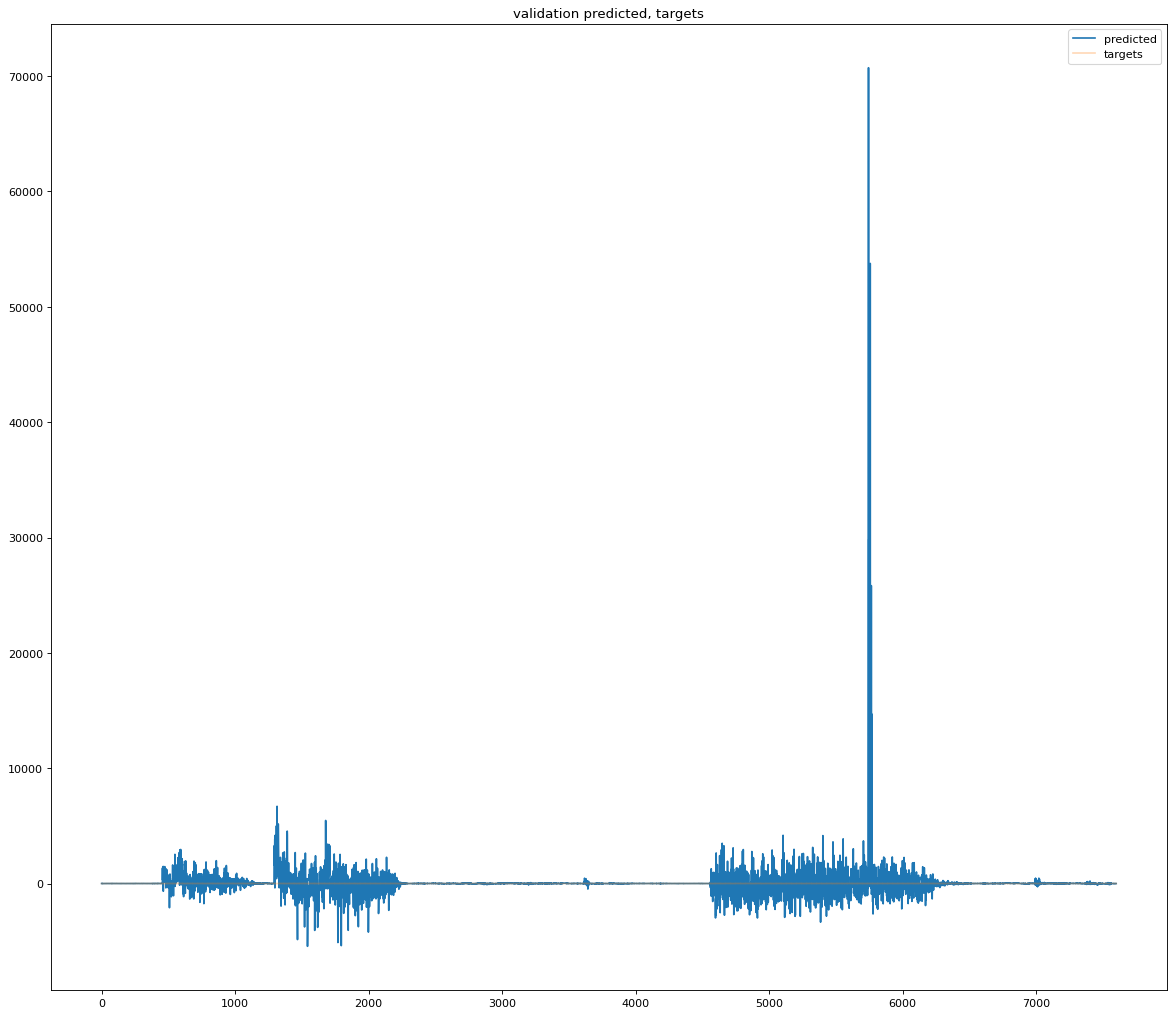

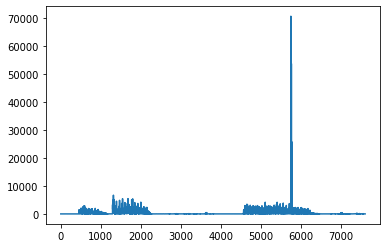

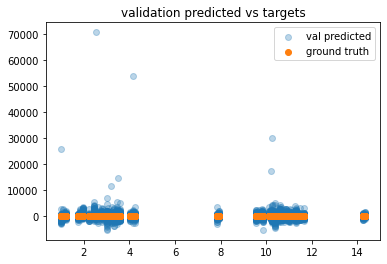

In [5]:
L = ScaledLinear()
A = PositionalEncoding(22)
mha = SimpleMultiheadAttention(22,1)

def EGNN2(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=2,
        num_nearest_neighbors=2, 
        dropout=0.05)
    #num_edge_tokens=2,
    #m_dim=10,
    #adj_dim=3,
    
    return net
n=EGNN2(150, 1)
param = nn.Parameter()
optimizer2 = torch.optim.Adam(list(n.parameters()) + list(mha.parameters()) + list(L.parameters()), lr=.009, weight_decay=0.02)
criterion = nn.HuberLoss()
losses=[]
preds=[]
Ts=[]
counter=0
for e in range(100):
    counter=0
    for pdb in pdbs[:-1]:#["10gs"]:#pdbs[:2]:
        plus=torch.tensor(list(pluses[pdb].values()))
        hoodo=hoodos[counter]
        counter+=1

        labels=all_labels[pdb]
        outs = []
        #labels=all_labels[pdb]
        for x in range(len(hoodo)):
                #le = h[0].shape[0]
                optimizer2.zero_grad()  
                add = plus[x]
                h=hoodo[x]
                #print(h[0].unsqueeze(0).detach(), torch.tensor(h[1].unsqueeze(0).detach()))
                o = n(torch.tensor(h[0]).unsqueeze(0).detach(), torch.tensor(h[1].unsqueeze(0).detach()))  # Forward pass
                T = torch.tensor(labels[x])
                pk3=torch.sum(torch.sum(torch.mean(mha(A(o[0][0].unsqueeze(2))), dim=0),dim=0))
                #print(pk3)
                pk = pk3 - L(add)
                #print(add,L(add)) # (add/le)
                loss = criterion(pk, T)
                if counter not in [0,9,15]:
                    loss.backward()  # Retain graph if necessary
                    optimizer2.step()
                    #print(add)
                else:
                    #print(round(out.item(),3), round(T.item(),3), round(loss.item(),3))
                    losses.append(loss.item())
                    preds.append(pk.item())
                    Ts.append(T.item())
                #print(x)

            
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")
#plt.ylim(0,10)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, label="ground truth")
plt.title("validation predicted vs targets")
#plt.ylim(2,14)
plt.legend()
plt.show()
     

In [20]:
data.targets["101m"]

{'GLU136A': 3.7713300000000003,
 'TYR146A': 13.6129,
 'GLU4A': 2.25904,
 'HIS93A': 5.31574,
 'LYS50A': 10.8014,
 'NTR0A': 6.65705,
 'LYS98A': 10.9292,
 'ASP44A': 2.638,
 'HIS116A': 6.72347,
 'LYS133A': 11.413,
 'LYS78A': 11.7077,
 'LYS62A': 11.4398,
 'HIS82A': 5.5784400000000005,
 'LYS79A': 11.5597,
 'ASP141A': 0.717805,
 'LYS147A': 10.6057,
 'GLU109A': 2.86417,
 'GLU52A': 2.41958,
 'LYS145A': 11.104000000000001,
 'ASP20A': 2.27782,
 'HIS64A': 4.6759,
 'GLU41A': 4.214580000000001,
 'LYS63A': 10.5078,
 'GLU148A': 3.76039,
 'TYR103A': 10.6609,
 'LYS16A': 10.4909,
 'GLU38A': 3.21513,
 'HIS119A': 4.85787,
 'GLU54A': 3.30059,
 'GLU83A': 2.62962,
 'ASP60A': 2.42593,
 'TYR151A': 11.3932,
 'GLU59A': 3.5670300000000004,
 'ASP27A': 2.74085,
 'LYS140A': 9.974739999999999,
 'LYS56A': 11.2915,
 'LYS87A': 10.6428,
 'LYS77A': 11.5607,
 'GLU6A': 1.9508299999999998,
 'LYS47A': 11.4367,
 'HIS81A': 6.584789999999999,
 'GLU18A': 2.76381,
 'LYS42A': 11.9572,
 'HIS97A': 5.8416,
 'LYS102A': 11.0808,
 'HIS24A

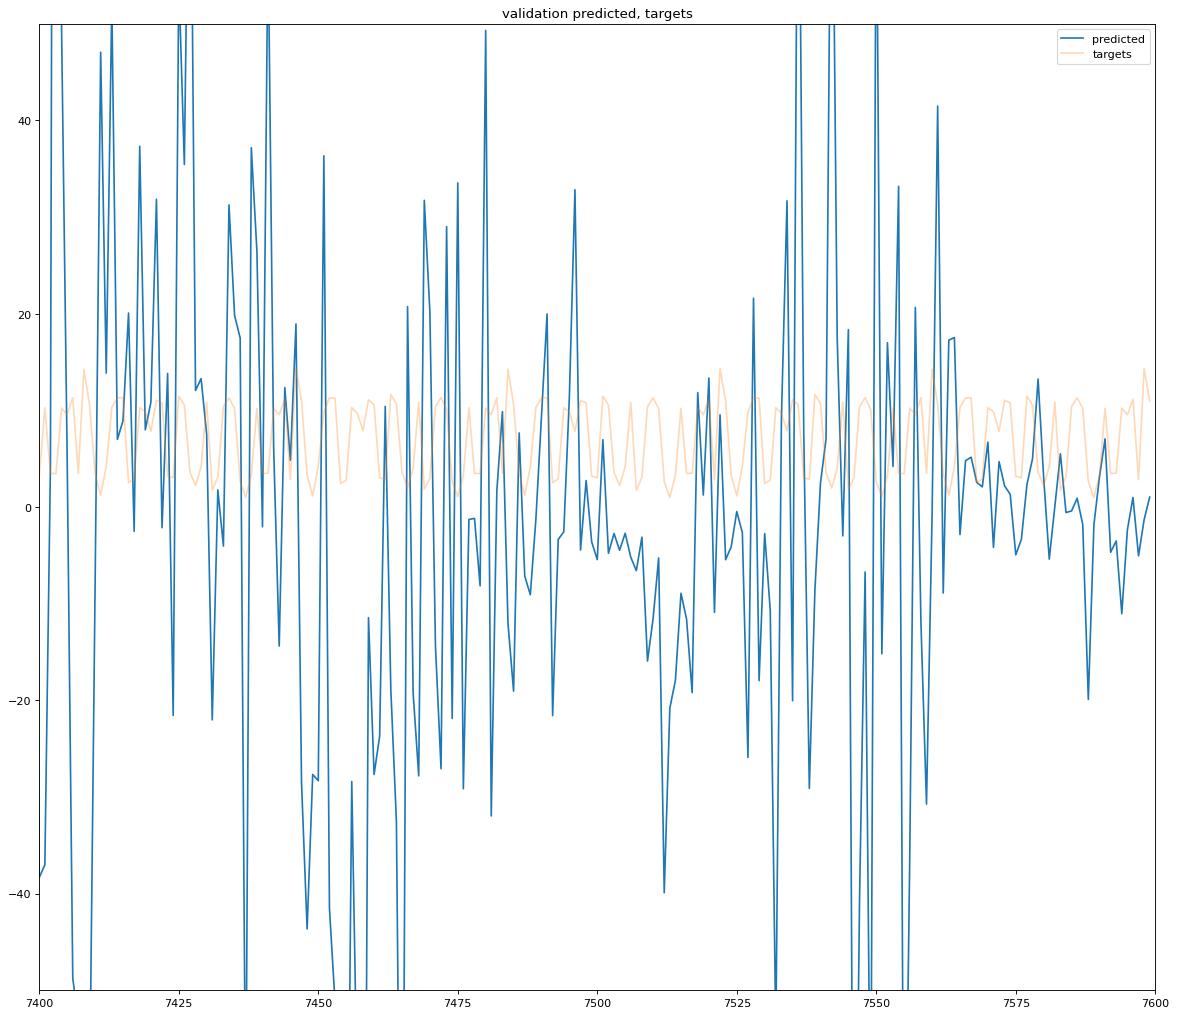

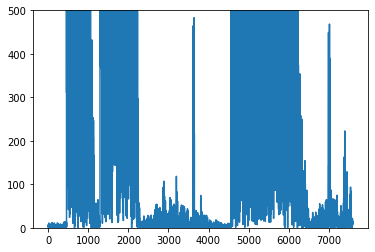

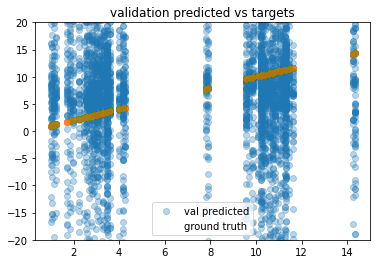

In [14]:
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.xlim(len(Ts)-200,len(Ts))
plt.ylim(-50,50)
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")
plt.ylim(0,500)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, alpha=0.01, label="ground truth")
plt.title("validation predicted vs targets")
plt.ylim(-20,20)
plt.legend()
plt.show()

In [37]:
pk
pk3
add

tensor(13.6099)

In [40]:
L(add) - pk3

tensor(0.6792, grad_fn=<SubBackward0>)

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


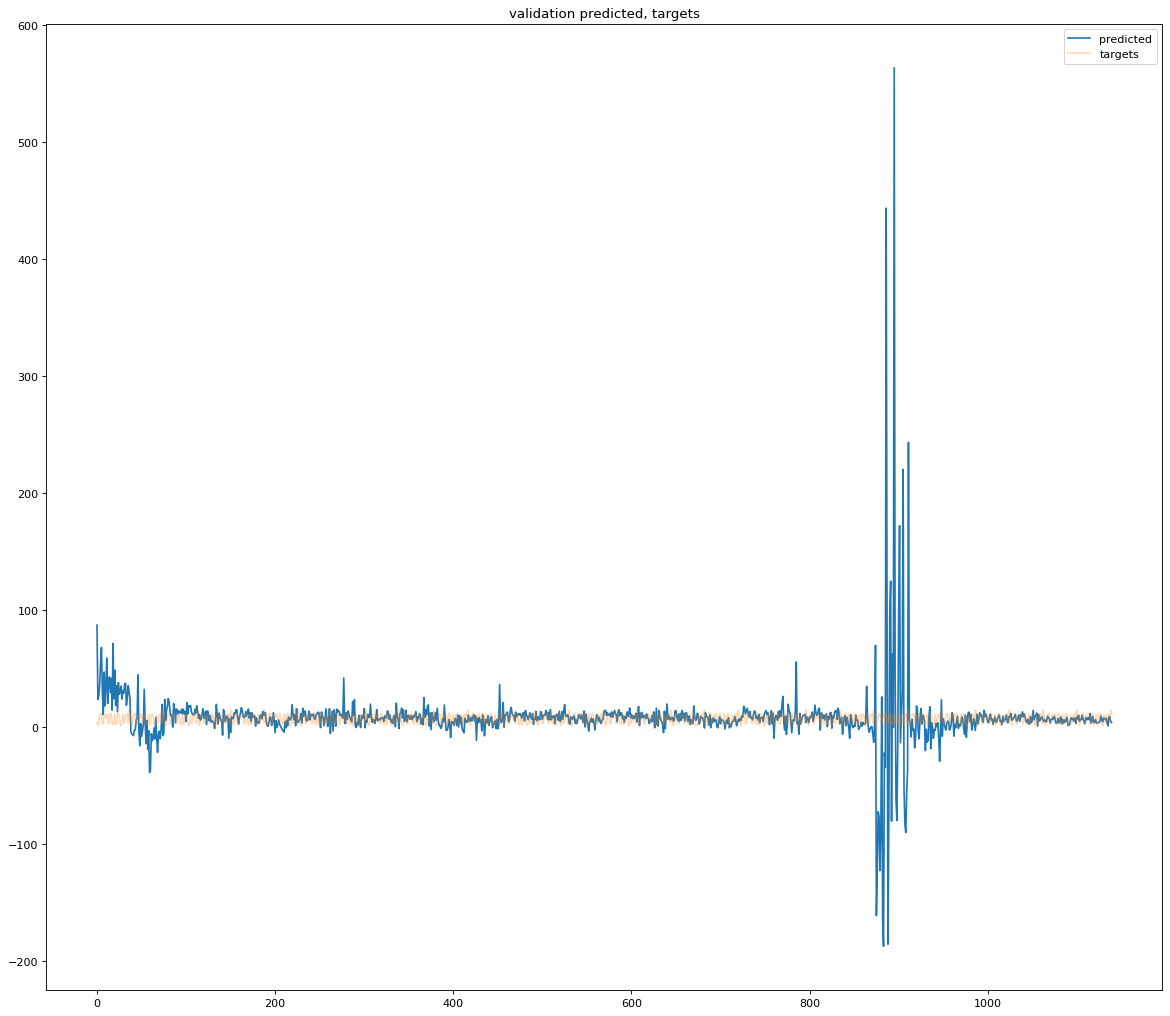

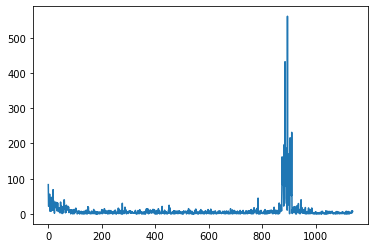

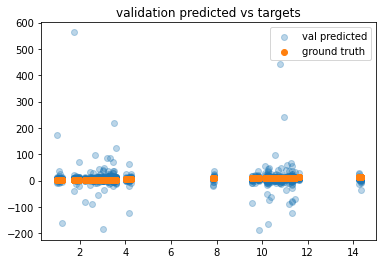

In [41]:
L = ScaledLinear()
A = PositionalEncoding(22)
mha = SimpleMultiheadAttention(22,1)

def EGNN2(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=3,
        num_nearest_neighbors=2, 
        dropout=0.05)
    #num_edge_tokens=2,
    #m_dim=10,
    #adj_dim=3,
    
    return net
n=EGNN2(150, 1)
param = nn.Parameter()
optimizer2 = torch.optim.Adam(list(n.parameters()) + list(mha.parameters()) + list(L.parameters()), lr=.008, weight_decay=0.02)
criterion = nn.HuberLoss()
losses=[]
preds=[]
Ts=[]
counter=0
for e in range(15):
    counter=0
    for pdb in pdbs[:-1]:#["10gs"]:#pdbs[:2]:
        plus=torch.tensor(list(pluses[pdb].values()))
        hoodo=hoodos[counter]
        counter+=1

        labels=all_labels[pdb]
        outs = []
        #labels=all_labels[pdb]
        for x in range(len(hoodo)):
                #le = h[0].shape[0]
                optimizer2.zero_grad()  
                add = plus[x]
                h=hoodo[x]
                #print(h[0].unsqueeze(0).detach(), torch.tensor(h[1].unsqueeze(0).detach()))
                o = n(torch.tensor(h[0]).unsqueeze(0).detach(), torch.tensor(h[1].unsqueeze(0).detach()))  # Forward pass
                T = torch.tensor(labels[x])
                pk3=torch.sum(torch.sum(torch.mean(mha(A(o[0][0].unsqueeze(2))), dim=0),dim=0))
                #print(pk3)
                pk = (L(add)/len(h)) - pk3
                #print(add,L(add)) # (add/le)
                loss = criterion(pk, T)
                if counter not in [0,9,15]:
                    loss.backward()  # Retain graph if necessary
                    optimizer2.step()
                    #print(add)
                else:
                    #print(round(out.item(),3), round(T.item(),3), round(loss.item(),3))
                    losses.append(loss.item())
                    preds.append(pk.item())
                    Ts.append(T.item())
                #print(x)

            
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")
#plt.ylim(0,10)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, label="ground truth")
plt.title("validation predicted vs targets")
#plt.ylim(2,14)
plt.legend()
plt.show()

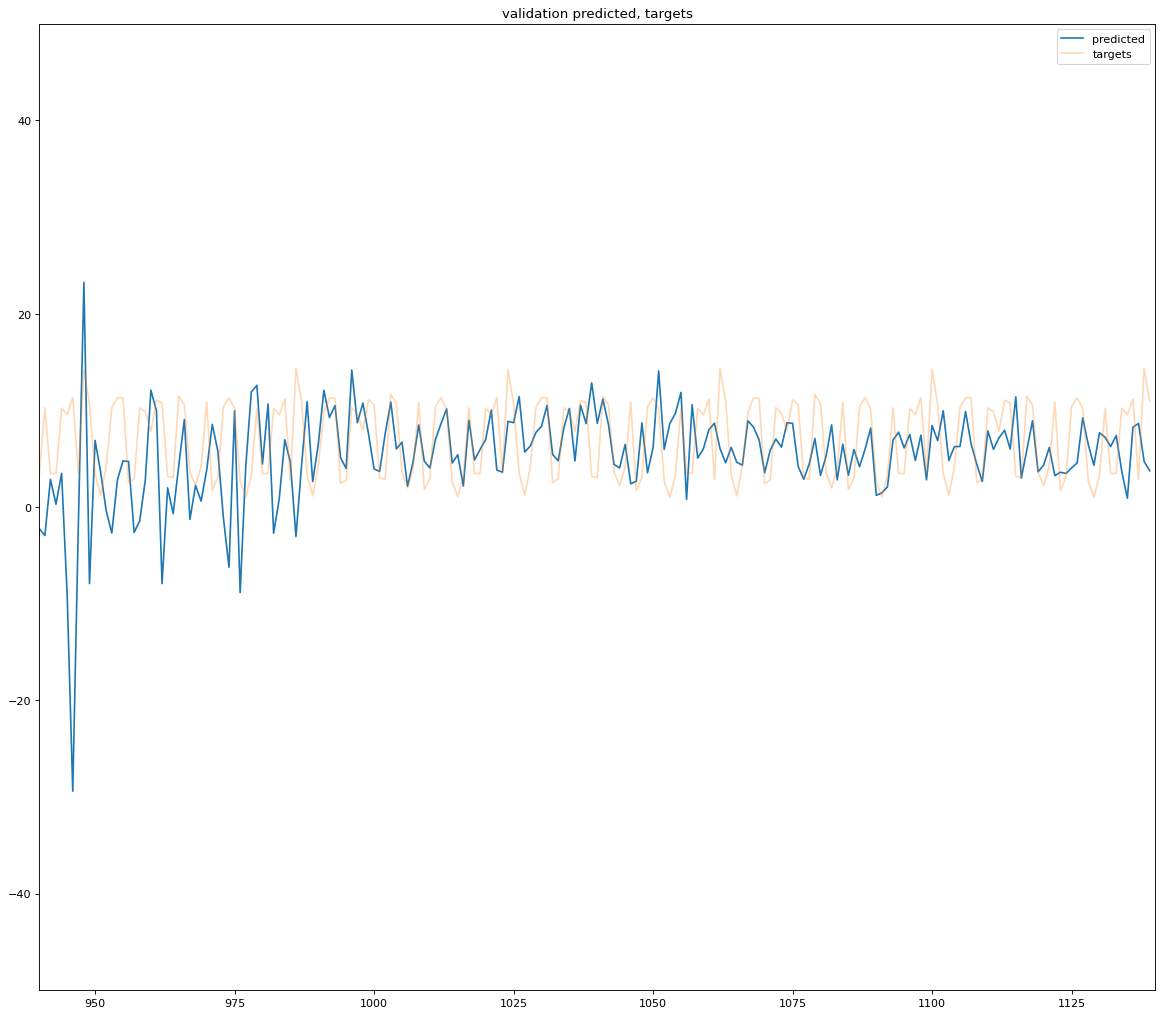

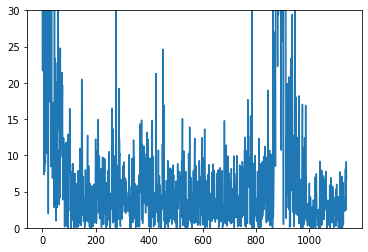

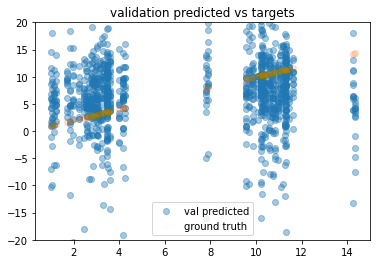

In [48]:
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.xlim(len(Ts)-200,len(Ts))
plt.ylim(-50,50)
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")
plt.ylim(0,30)
plt.show()
plt.scatter(Ts, preds,alpha=0.4, label="val predicted")
plt.scatter(Ts,Ts, alpha=0.01, label="ground truth")
plt.title("validation predicted vs targets")
plt.ylim(-20,20)
plt.legend()
plt.show()

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


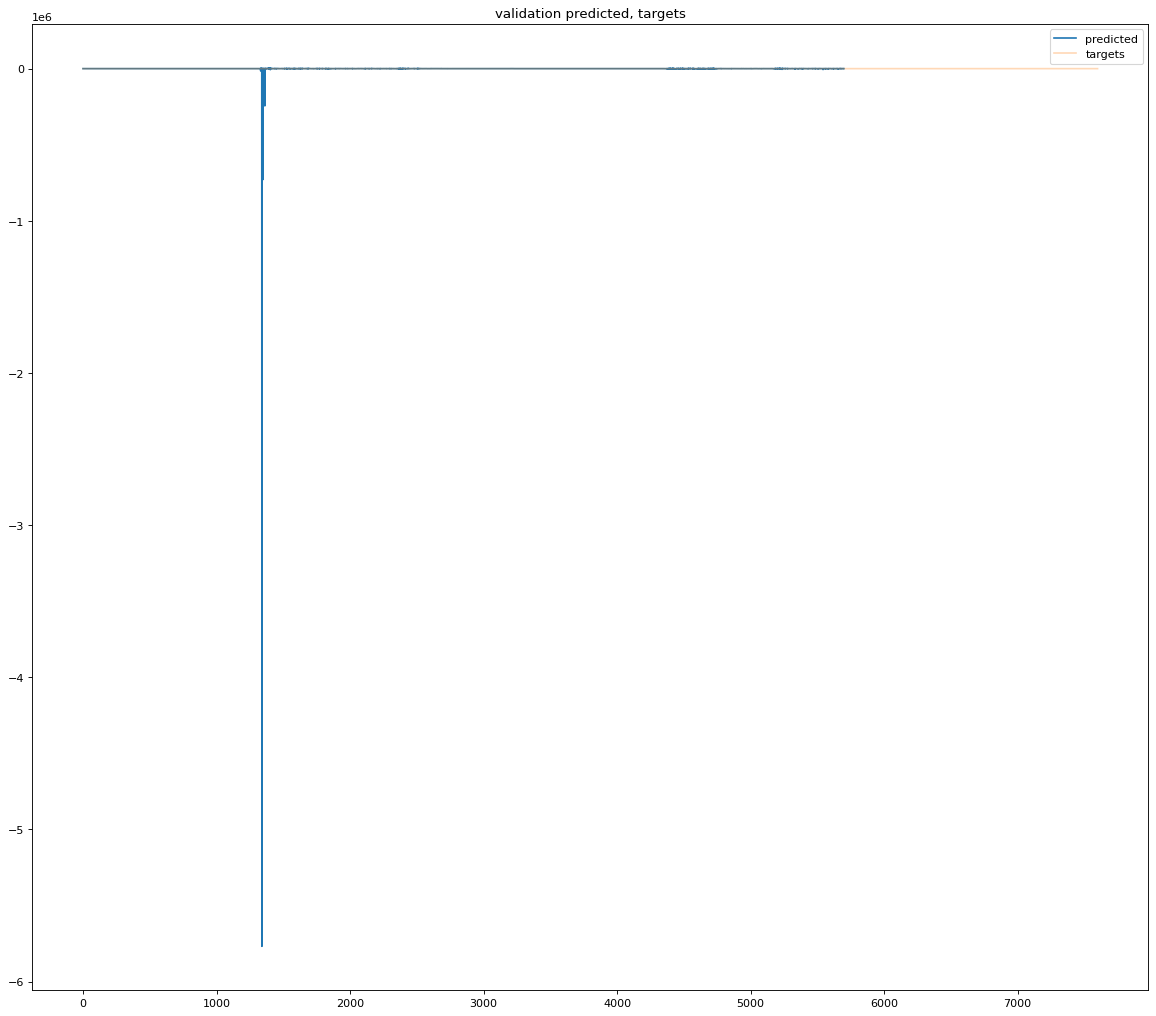

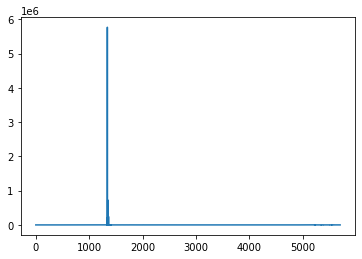

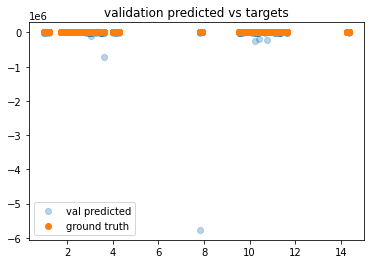

In [49]:
L = ScaledLinear()
A = PositionalEncoding(22)
mha = SimpleMultiheadAttention(22,1)

def EGNN2(num_nodes, depth):
    """This layer creates an embedding as well as hopefully navigates dimerrors produced by putting molecules with
    varying node size. 
    in
    feats = 1 x n_atoms

    input can be minimum one atom, this accomdates for rogue solo cofactors and unhydrogonated water."""
    net = EGNN_Network(
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=3,
        num_nearest_neighbors=2, 
        dropout=0.06)
    #num_edge_tokens=2,
    #m_dim=10,
    #adj_dim=3,
    
    return net
n=EGNN2(150, 1)
param = nn.Parameter()
optimizer2 = torch.optim.Adam(list(n.parameters()) + list(mha.parameters()) + list(L.parameters()), lr=.007, weight_decay=0.02)
criterion = nn.HuberLoss()
losses=[]
preds=[]
Ts=[]
counter=0
for e in range(100):
    counter=0
    for pdb in pdbs[:-1]:#["10gs"]:#pdbs[:2]:
        plus=torch.tensor(list(pluses[pdb].values()))
        hoodo=hoodos[counter]
        counter+=1

        labels=all_labels[pdb]
        outs = []
        #labels=all_labels[pdb]
        for x in range(len(hoodo)):
                #le = h[0].shape[0]
                optimizer2.zero_grad()  
                add = plus[x]
                h=hoodo[x]
                #print(h[0].unsqueeze(0).detach(), torch.tensor(h[1].unsqueeze(0).detach()))
                o = n(torch.tensor(h[0]).unsqueeze(0).detach(), torch.tensor(h[1].unsqueeze(0).detach()))  # Forward pass
                T = torch.tensor(labels[x])
                pk3=torch.sum(torch.sum(torch.mean(mha(A(o[0][0].unsqueeze(2))), dim=0),dim=0))
                #print(pk3)
                pk = 0.5*((L(add)/len(h)) - pk3)
                #print(add,L(add)) # (add/le)
                loss = criterion(pk, T)
                if counter not in [0,9,15]:
                    loss.backward()  # Retain graph if necessary
                    optimizer2.step()
                    #print(add)
                else:
                    #print(round(out.item(),3), round(T.item(),3), round(loss.item(),3))
                    losses.append(loss.item())
                    preds.append(pk.item())
                    Ts.append(T.item())
                #print(x)

            
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")
#plt.ylim(0,10)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, label="ground truth")
plt.title("validation predicted vs targets")
#plt.ylim(2,14)
plt.legend()
plt.show()

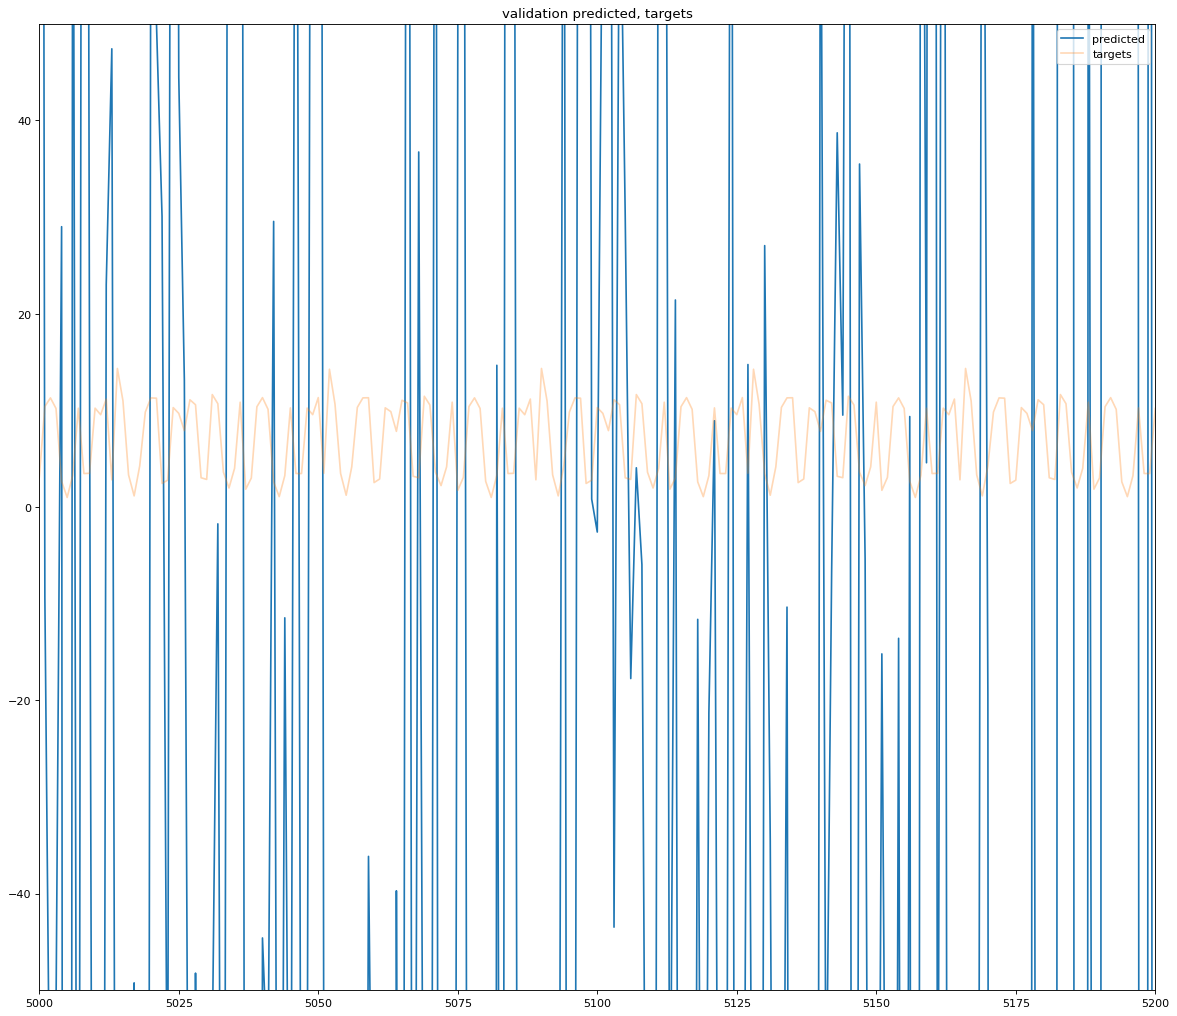

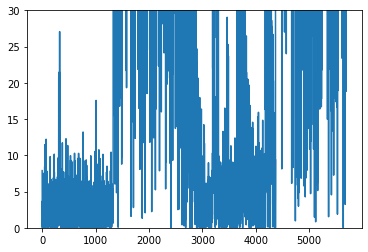

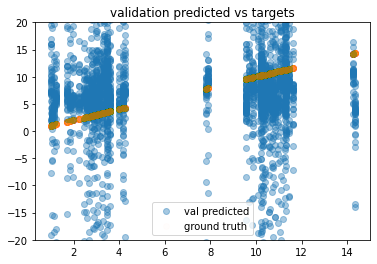

In [52]:
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.xlim(5000,5200)
plt.ylim(-50,50)
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")
plt.ylim(0,30)
plt.show()
plt.scatter(Ts, preds,alpha=0.4, label="val predicted")
plt.scatter(Ts,Ts, alpha=0.01, label="ground truth")
plt.title("validation predicted vs targets")
plt.ylim(-20,20)
plt.legend()
plt.show()

reproducability check of the best one above, and put 10gs in training and validation size from 3:17 to 4:16

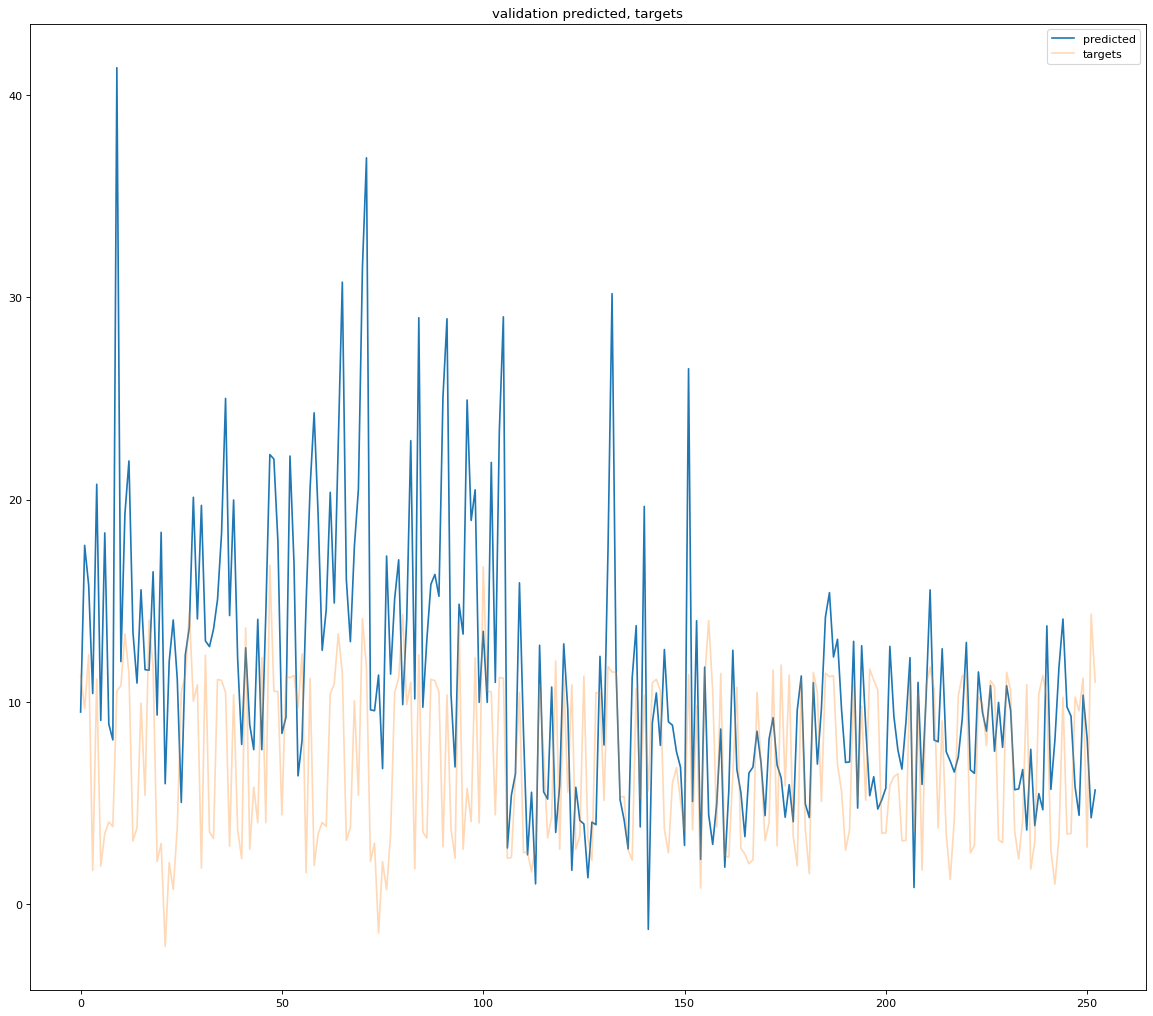

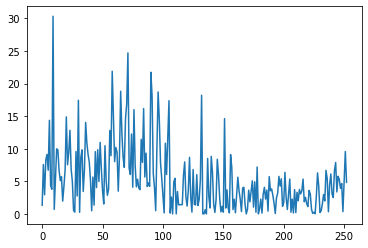

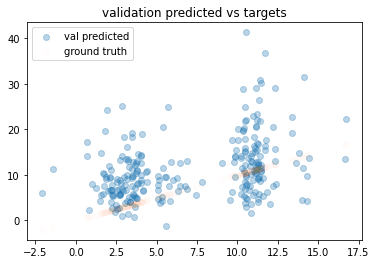

In [60]:
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")
#plt.ylim(0,10)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, alpha=0.01, label="ground truth")
plt.title("validation predicted vs targets")
#plt.ylim(2,14)
plt.legend()
plt.show()

/home/jrhoernschemeyer/.local/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


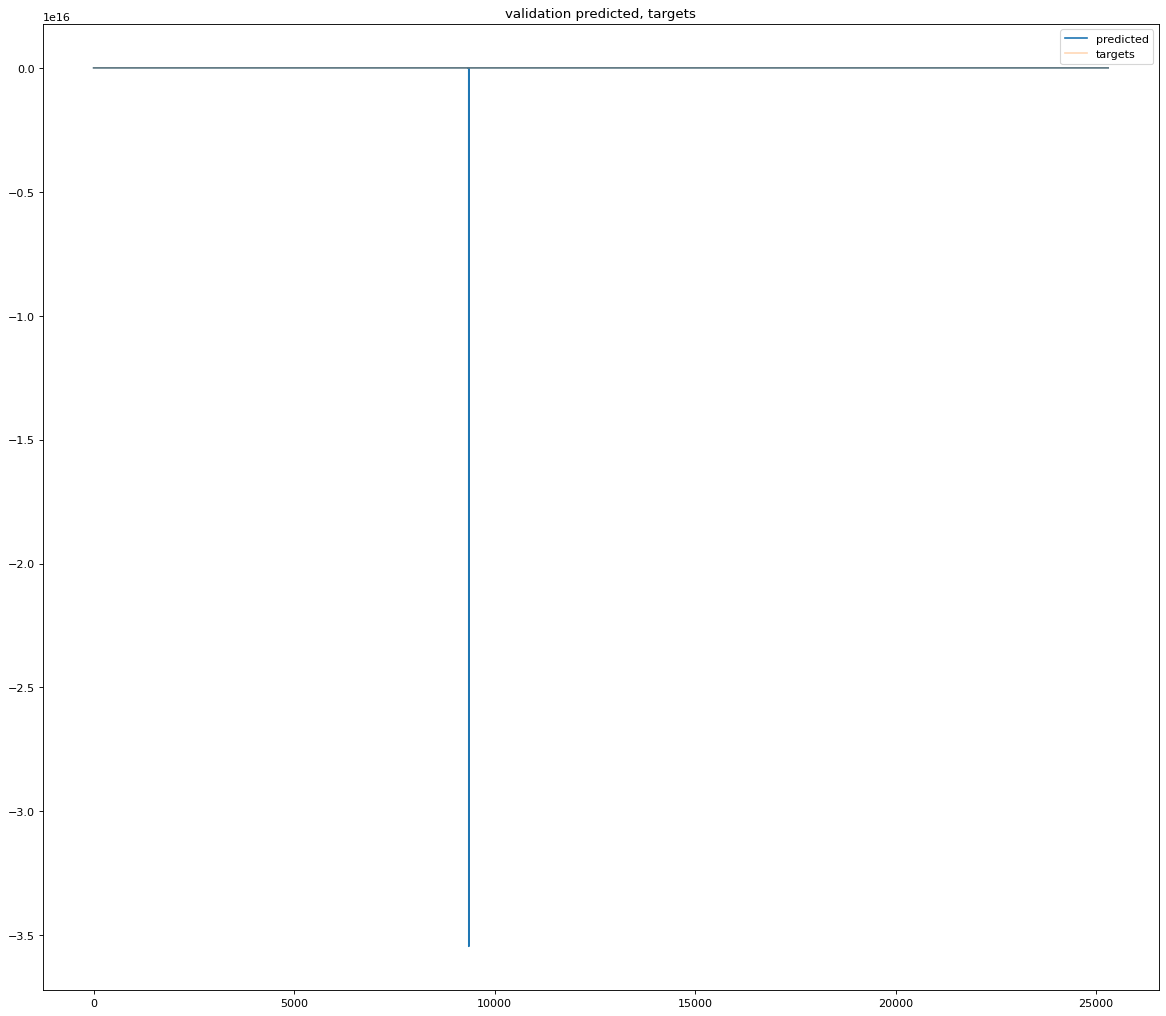

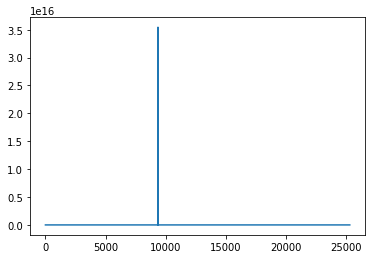

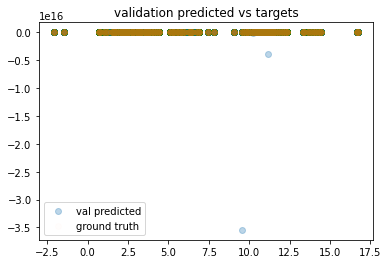

In [66]:
L = ScaledLinear()
A = PositionalEncoding(22)
mha = SimpleMultiheadAttention(22,1)

def EGNN2(num_nodes, depth):
    """no hydrogens here. input feats is the output from egnn1, with a mask to exclude the hydrogens atoms, and assembled in neighborhoods, with laplace taken on it.
    input coords is output coords of egnn1 (layer1)."""
    net = EGNN_Network(
        num_positions = num_nodes, # unless what you are passing in is an unordered set, set this to the maximum sequence length
        dim = 3,
        depth=3,
        num_nearest_neighbors=2, 
        dropout=0.05)
    #num_edge_tokens=2,
    #m_dim=10,
    #adj_dim=3,
    
    return net
n=EGNN2(150, 1)
param = nn.Parameter()
optimizer2 = torch.optim.Adam(list(n.parameters()) + list(mha.parameters()) + list(L.parameters()), lr=.008, weight_decay=0.03)
criterion = nn.HuberLoss()
losses=[]
preds=[]
Ts=[]
counter=0
for e in range(100):
    counter=0
    for pdb in pdbs[:-1]:#["10gs"]:#pdbs[:2]:
        plus=torch.tensor(list(pluses[pdb].values()))
        hoodo=hoodos[counter]
        counter+=1

        labels=all_labels[pdb]
        outs = []
        #labels=all_labels[pdb]
        for x in range(len(hoodo)):
                #le = h[0].shape[0]
                optimizer2.zero_grad()  
                add = plus[x]
                h=hoodo[x]
                #print(h[0].unsqueeze(0).detach(), torch.tensor(h[1].unsqueeze(0).detach()))
                o = n(torch.tensor(h[0]).unsqueeze(0).detach(), torch.tensor(h[1].unsqueeze(0).detach()))  # Forward pass
                T = torch.tensor(labels[x])
                pk3=torch.sum(torch.sum(torch.mean(mha(A(o[0][0].unsqueeze(2))), dim=0),dim=0))
                #print(pk3)
                pk = .5*((L(add)/len(h)) - pk3)
                #print(pk,pk3,add)
                #print(add,L(add)) # (add/le)
                loss = criterion(pk, T)
                if counter not in [1,4,12,15]:
                    loss.backward()  # Retain graph if necessary
                    optimizer2.step()
                    #print(add)
                else:
                    #print(round(out.item(),3), round(T.item(),3), round(loss.item(),3))
                    losses.append(loss.item())
                    preds.append(pk.item())
                    Ts.append(T.item())
                #print(x)

            
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")
#plt.ylim(0,10)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, alpha=0.01, label="ground truth")
plt.title("validation predicted vs targets")
#plt.ylim(2,14)
plt.legend()
plt.show()

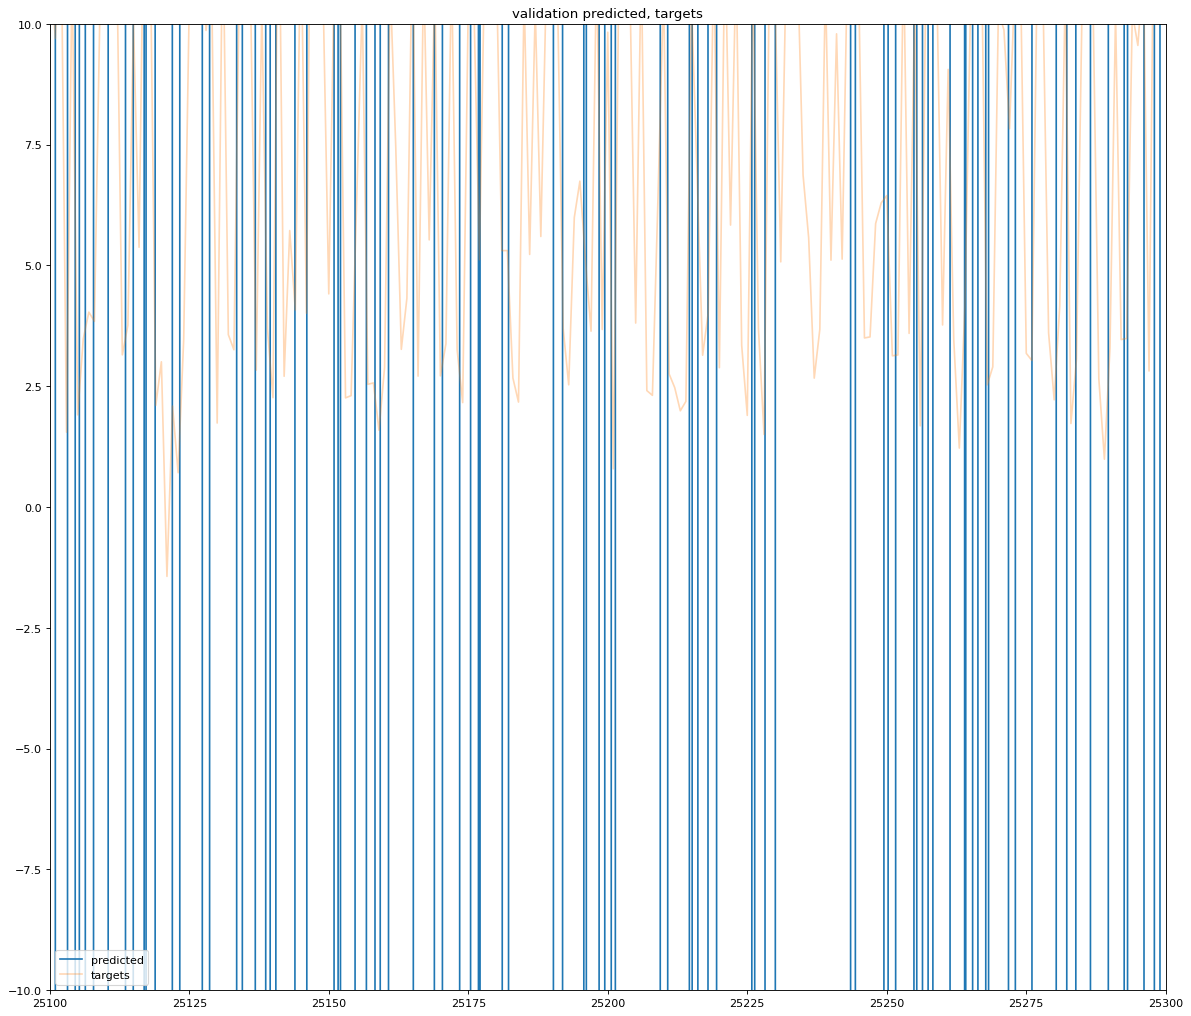

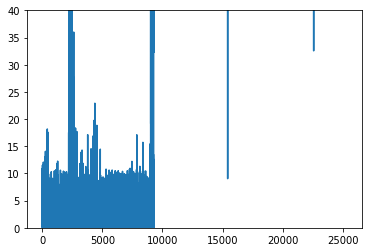

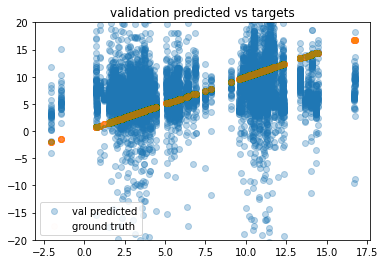

In [69]:
plt.figure(figsize=(18, 16), dpi=80)
plt.plot(preds, label="predicted")
plt.plot(Ts,alpha=0.3,label="targets")
plt.xlim(len(Ts)-200,len(Ts))
plt.ylim(-10,10)
plt.legend()
plt.title("validation predicted, targets")
plt.show()
plt.plot(losses)
#plt.title("val loss, no hydrogens, 100 epoch, lr+wd .01 \n egnn1 = whole amino acid, egnn2 = 4 angstrom from a sc atom")

plt.ylim(0,40)
plt.show()
plt.scatter(Ts, preds,alpha=0.3, label="val predicted")
plt.scatter(Ts,Ts, alpha=0.01, label="ground truth")
plt.title("validation predicted vs targets")
plt.ylim(-20,20)
plt.legend()
plt.show()